In [152]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

In [153]:
# 1. ბაზასთან კავშირის დამყარება
conn = sqlite3.connect('euro_summary.sqlite3')
cursor = conn.cursor()

In [154]:
# 2. არსებული ცხრილების შემოწმება
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("არსებული ცხრილები:", tables)

try:
    df = pd.read_sql("SELECT * FROM euro_summary", conn)
    print("მონაცემები წარმატებით ჩაიტვირთა:")
    print(df.head())
    
except Exception as e:
    print(f"შეცდომა მონაცემების ჩატვირთვისას: {e}")
    df = pd.DataFrame(columns=['Year', 'Winner', 'Final_Result', 'Matches', 'Goals', 'Red_Cards', 'Attendance'])
    print("შეიქმნა ცარიელი DataFrame")

არსებული ცხრილები: [('euro_summary',)]
მონაცემები წარმატებით ჩაიტვირთა:
   Year          Winner   Final Result  Matches  Goals  Red Cards  Attendance  \
0  1968           Italy          2 - 0      5.0    7.0        1.0    260936.0   
1  1976  Czechoslovakia  2 - 2 (5 - 3)      4.0   19.0        3.0    106087.0   
2  1980    West Germany            2-1     14.0   27.0        0.0    350655.0   
3  1984          France          2 - 0     15.0   41.0        3.0    599655.0   
4  1992         Denmark          2 - 0     15.0   32.0        0.0    429833.0   

   Attendance Avg  Goals Avg  Red Cards Avg  
0        52187.20       1.40           0.20  
1        26521.75       4.75           0.75  
2        25046.79       1.93           0.00  
3        39977.00       2.73           0.20  
4        28655.53       2.13           0.00  


In [155]:
# 3. ფუნქცია გამარჯვებულის მოსაძებნად წლის მიხედვით
def euro_winner(year):
    """წელიწადის მიხედვით აბრუნებს ევროპის ჩემპიონატის გამარჯვებულს"""
    cursor.execute('SELECT Winner FROM euro_summary WHERE Year=?', (year,))
    result = cursor.fetchone()
    return result[0] if result else None


# ტესტირება
try:
    print("2016 წლის ევროპის ჩემპიონატის გამარჯვებული :", euro_winner(2016))
    print("2020 წლის ევროპის ჩემპიონატის გამარჯვებული:", euro_winner(2020))
    print("2024  წლის ევროპის ჩემპიონატის გამარჯვებული:", euro_winner(2024))
    
except Exception as e:
    print(f"შეცდომა: {e}")

2016 წლის ევროპის ჩემპიონატის გამარჯვებული : Portugal
2020 წლის ევროპის ჩემპიონატის გამარჯვებული: Italy
2024  წლის ევროპის ჩემპიონატის გამარჯვებული: Spain


In [156]:
# 4. გამარჯვებულის განახლება
try:
    new_winners_year = int(input('შეიყვანეთ წელი: '))
    new_winner = input('შეიყვანეთ ახალი გამარჯვებული ქვეყანა: ')

    if new_winners_year % 4 != 0:
        raise ValueError('ევროპის ჩემპიონატი ფეხბურთში მხოლოდ ნაკიან წლებში იმართება!')

    cursor.execute("UPDATE euro_summary SET Winner = ? WHERE Year = ?", (new_winner, new_winners_year))
    conn.commit()
    print(f"{new_winners_year} წლის გამარჯვებული განახლებულია: {new_winner}")
except ValueError as ve:
    print(f"შეცდომა: {ve}")
except Exception as e:
    print(f"მოულოდნელი შეცდომა: {e}")


1960 წლის გამარჯვებული განახლებულია: USSR


In [157]:
# 5. ახალი ჩანაწერის დამატება ან განახლება
try:
    new_winner = input('\nშეიყვანეთ გამარჯვებული ქვეყანა: ')
    new_year = int(input('შეიყვანეთ წელი: '))

    if new_year % 4 != 0:
        raise ValueError('ევროპის ჩემპიონატი ფეხბურთში მხოლოდ ნაკიან წლებში იმართება!')

    cursor.execute('SELECT Year FROM euro_summary WHERE Year = ?', (new_year,))
    existing_record = cursor.fetchone()

    if existing_record:
        cursor.execute('UPDATE euro_summary SET Winner = ? WHERE Year = ?',
                       (new_winner, new_year))
        action = "განახლებულია"
    else:
        cursor.execute('INSERT INTO euro_summary (Year, Winner) VALUES (?, ?)',
                       (new_year, new_winner))
        action = "დამატებულია"

    conn.commit()
    print(f"{new_year} წლის ჩანაწერი {action}!")
except ValueError as ve:
    print(f"შეცდომა: {ve}")
except Exception as e:
    print(f"მოულოდნელი შეცდომა: {e}")


1964 წლის ჩანაწერი განახლებულია!


In [158]:
# 6. ჩანაწერის წაშლა
try:
    year_to_delete = int(input('\nშეიყვანეთ წელი წასაშლელად: '))
    cursor.execute('DELETE FROM euro_summary WHERE Year = ?', (year_to_delete,))
    conn.commit()

    if cursor.rowcount > 0:
        print(f'წარმატებით წაიშალა {cursor.rowcount} ჩანაწერი {year_to_delete} წლისთვის')
    else:
        print(f'{year_to_delete} წელს არ მოიძებნა ჩანაწერები ბაზაში')
except Exception as e:
    print(f"შეცდომა: {e}")

წარმატებით წაიშალა 1 ჩანაწერი 2000 წლისთვის


In [159]:
# 7. მონაცემთა ვიზუალიზაცია
def visualize_data():
    """მონაცემთა ვიზუალიზაცია სხვადასხვა დიაგრამებში"""
    df = pd.read_sql("SELECT * FROM euro_summary ORDER BY Year", conn)


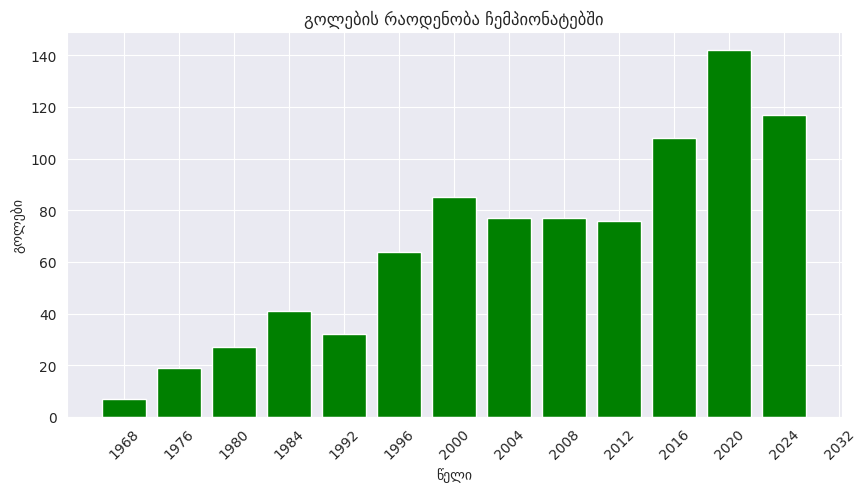

In [160]:
# დიაგრამა 1: გოლების რაოდენობა წლების მიხედვით
plt.figure(figsize=(10, 5))
plt.bar(df['Year'].astype(str), df['Goals'], color='green')
plt.title("გოლების რაოდენობა ჩემპიონატებში")
plt.xlabel("წელი")
plt.ylabel("გოლები")
plt.xticks(rotation=45)
plt.show()

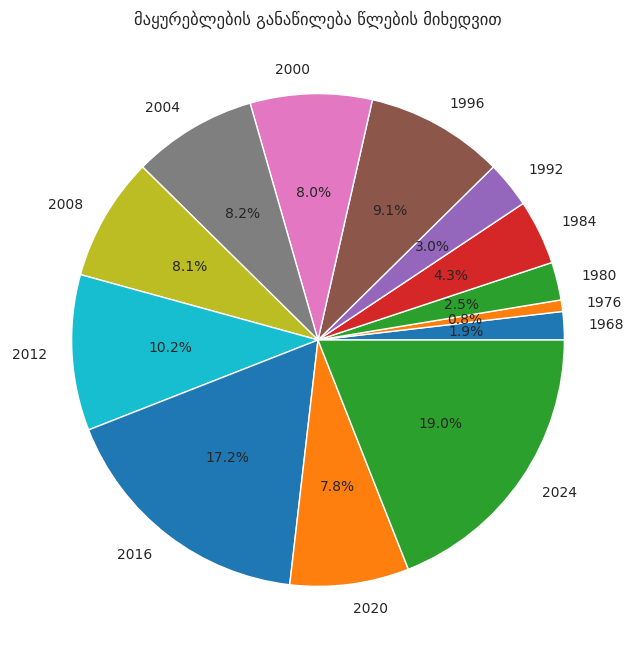

In [161]:
# დიაგრამა 2: მაყურებლების რაოდენობის წრიული დიაგრამა
df_clean = df.dropna(subset=['Attendance'])

if df_clean.empty:
    print("მონაცემები მაყურებლების შესახებ არ არის საკმარისი პაი დიაგრამისთვის.")
else:
    plt.figure(figsize=(8, 8))
    plt.pie(df_clean['Attendance'], labels=df_clean['Year'].astype(str), autopct='%1.1f%%')
    plt.title("მაყურებლების განაწილება წლების მიხედვით")
    plt.show()

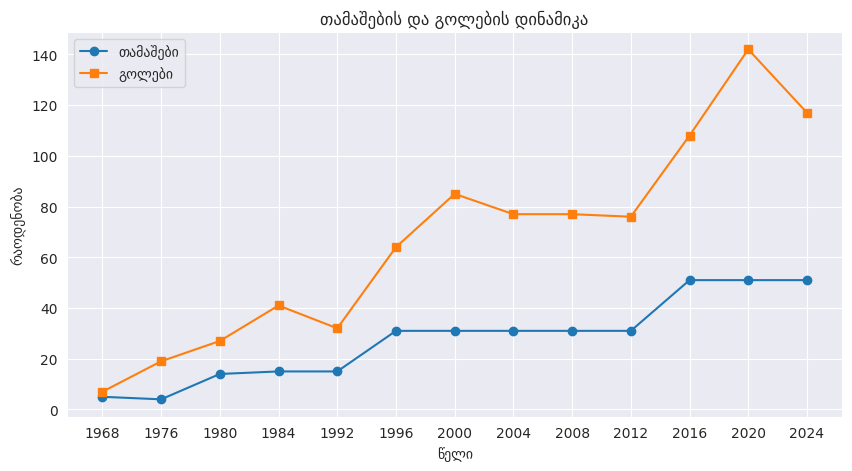

In [162]:
# დიაგრამა 3: თამაშების და გოლების ტენდენცია
plt.figure(figsize=(10, 5))
plt.plot(df['Year'].astype(str), df['Matches'], marker='o', label='თამაშები')
plt.plot(df['Year'].astype(str), df['Goals'], marker='s', label='გოლები')
plt.title("თამაშების და გოლების დინამიკა")
plt.xlabel("წელი")
plt.ylabel("რაოდენობა")
plt.legend()
plt.grid(True)
plt.show()

In [163]:
visualize_data()

In [164]:
# 8. ბაზასთან კავშირის დახურვა
conn.close()
print("\nბაზასთან კავშირი დახურულია.")


ბაზასთან კავშირი დახურულია.
